Lasso weights:
array([  0.        ,   0.        , 274.33128438,  48.57203696,
         0.        ,   0.        ,  -0.        ,   0.        ,
       424.12142666,   0.        ])

Ridge weights:
array([  20.86588099,  -58.00039065,  231.2704688 ,  186.67010355,
         33.31087207,   -2.16994737, -150.95049376,  141.35036492,
        250.75391278,  123.18025806])
root mean square error: 	58.30429511391227
mean absolute error: 		49.602750809651916
r2 score: 			0.3599020220009461
RMSE best params: 	{'alpha': 0.1}
MAE best params: 	{'alpha': 0.004641588833612777}
R2 best params: 	{'alpha': 0.1}



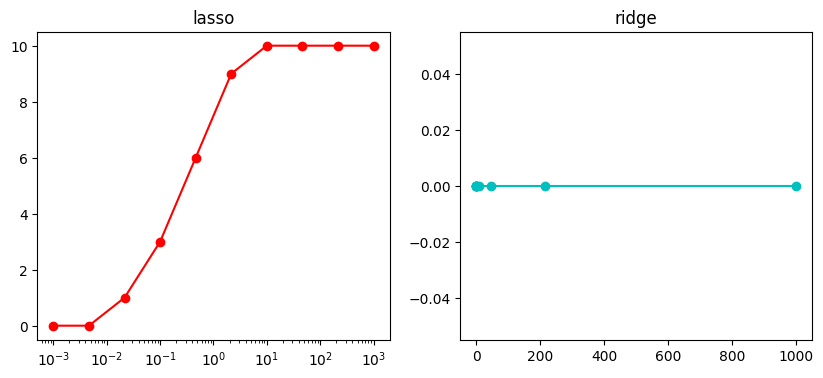

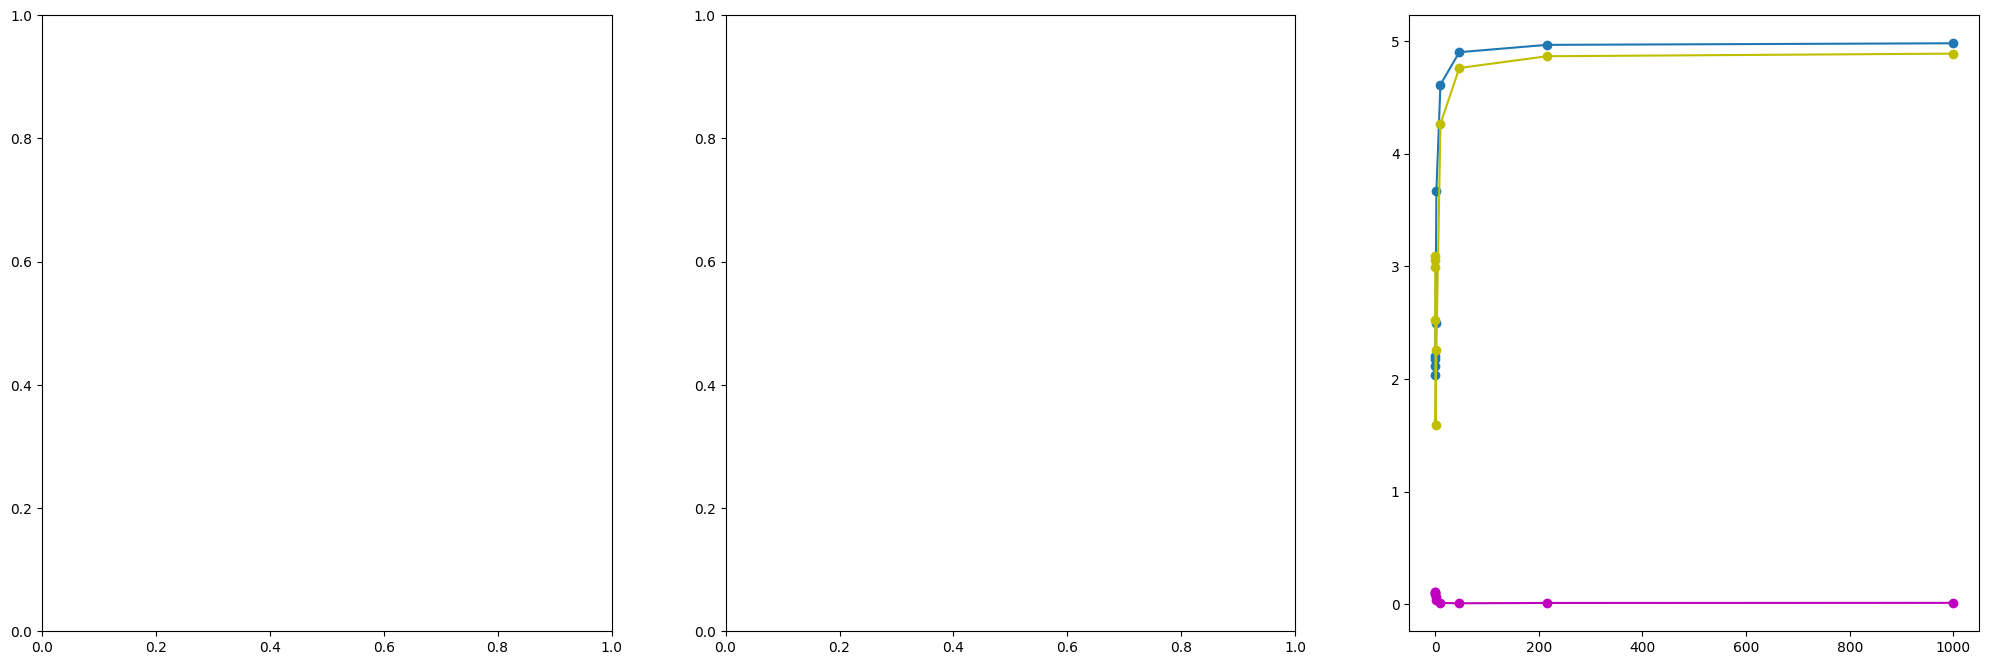

root mean square error: 	55.64176122404913
mean absolute error: 		47.071644521338236
r2 score: 			0.41702880920983465
MSE: 	3399.3908287301742


(array([177.,  53.,  38.,  21.,  10.,   4.,   2.,   2.,   1.,   1.]),
 array([4.69473046e-01, 2.70749476e+03, 5.41452005e+03, 8.12154534e+03,
        1.08285706e+04, 1.35355959e+04, 1.62426212e+04, 1.89496465e+04,
        2.16566718e+04, 2.43636971e+04, 2.70707224e+04]),
 <BarContainer object of 10 artists>)

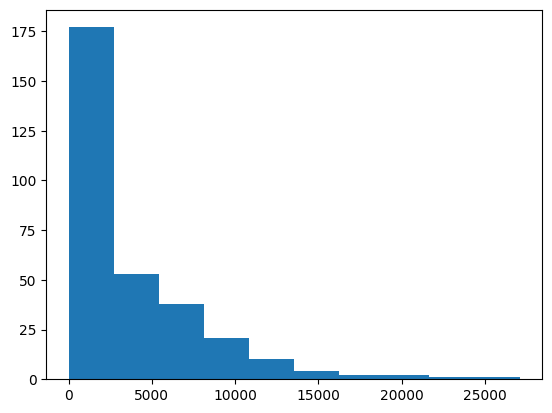

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scipy.special import expit
from itertools import cycle
from time import process_time_ns

from sklearn.datasets import load_diabetes, make_classification
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

#загрузка данных и разделение выборки
data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)


scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
#обучение регрессий и построение графиков
lasso = Lasso()
ridge = Ridge()

lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)

print('Lasso weights:', repr(lasso.coef_), '\nRidge weights:', repr(ridge.coef_), sep='\n')

x_axis = np.logspace(-3, 3, 10)
lasso_weights = np.empty((x_axis.shape[0], X_train.shape[1]))
ridge_weights = np.empty((x_axis.shape[0], X_train.shape[1]))

for iteration, coef in enumerate(x_axis):
    lasso = Lasso(alpha=coef)
    ridge = Ridge(alpha=coef)

    lasso.fit(X_train, y_train)
    ridge.fit(X_train, y_train)

    lasso_weights[iteration] = lasso.coef_
    ridge_weights[iteration] = ridge.coef_


fig, (lasso_plot, ridge_plot) = plt.subplots(1, 2, figsize=(10, 4))
lasso_plot.plot(x_axis, np.sum(np.isclose(lasso_weights, 0), axis=1), 'ro-')
ridge_plot.plot(x_axis, np.sum(np.isclose(ridge_weights, 0), axis=1), 'co-')
lasso_plot.set_title('lasso'), ridge_plot.set_title('ridge')
lasso_plot.set_xscale('log')

#подсчет метрик
ridge = Ridge()
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)

print('root mean square error: ', mean_squared_error(y_test, pred, squared=False), sep='\t')
print('mean absolute error: ', mean_absolute_error(y_test, pred), sep='\t\t')
print('r2 score: ', r2_score(y_test, pred), sep='\t\t\t')


#подбор коэффициента регуляризации
cross_validation = KFold(n_splits=5,shuffle=True)
params = {
    #'alpha':np.arange(0.001,1,0.001)
    'alpha':np.logspace(-3,3, 10)
}
grid_search_rmse = GridSearchCV(ridge, params, n_jobs=-1, cv=cross_validation.split(X_train, y_train),
                                scoring=make_scorer(
                                    lambda y_t, y_p: mean_squared_error(y_t, y_p, squared=False),
                                    greater_is_better=False)
                                )
grid_search_mae = GridSearchCV(ridge, params, n_jobs=-1, cv=cross_validation.split(X_train, y_train),
                               scoring=make_scorer(mean_absolute_error, greater_is_better=False))
grid_search_r2 = GridSearchCV(ridge, params, n_jobs=-1, cv=cross_validation.split(X_train, y_train),
                              scoring=make_scorer(r2_score))

grid_search_rmse.fit(X_train, y_train)
grid_search_mae.fit(X_train, y_train)
grid_search_r2.fit(X_train, y_train)

print('RMSE best params: ', grid_search_rmse.best_params_, sep='\t')
print('MAE best params: ', grid_search_mae.best_params_, sep='\t')
print('R2 best params: ', grid_search_r2.best_params_, sep='\t', end='\n\n')

fig, (rmse_plot, mae_plot, r2_plot) = plt.subplots(1, 3, figsize=(25, 8))
x_axis = np.logspace(-3, 3, 10)
#x_axis = np.arange(0.001,1,0.001)

plt.plot(x_axis, grid_search_rmse.cv_results_['std_test_score'], 'o-')

plt.plot(x_axis, grid_search_mae.cv_results_['std_test_score'], 'yo-')

plt.plot(x_axis, grid_search_r2.cv_results_['std_test_score'], 'mo-')
plt.show()
#rmse_plot.set_xscale('log'), mae_plot.set_xscale('log'), r2_plot.set_xscale('log')


pred_rmse = grid_search_rmse.predict(X_test)
pred_mae = grid_search_mae.predict(X_test)
pred_r2 = grid_search_r2.predict(X_test)
print('root mean square error: ', mean_squared_error(y_test, pred_rmse, squared=False), sep='\t')
print('mean absolute error: ', mean_absolute_error(y_test, pred_mae), sep='\t\t')
print('r2 score: ', r2_score(y_test, pred_r2), sep='\t\t\t')

plt.show()
#out fold предсказания
ridge = Ridge(alpha=1)
cv_pred = cross_val_predict(ridge, X_train, y_train, n_jobs=-1,
                            cv=cross_validation.split(X_train, y_train))
ridge.fit(X_train, y_train)
print('MSE: ', mean_squared_error(y_test, ridge.predict(X_test)), sep='\t')
errors = (y_train - cv_pred)** 2
plt.hist(errors)